# Expression Recognition

# 1. Importing, exploring and cleaning ISEAR dataset

In [68]:
!git clone https://github.com/Bhattars1/MSc-Project-Expression-Recognition-

fatal: destination path 'MSc-Project-Expression-Recognition-' already exists and is not an empty directory.


In [69]:
# Import function for geoemotion dataset
import pandas as pd
def upload_go(path):
  df = pd.read_csv(path)
  return df

In [70]:
go_path_1 ="/content/MSc-Project-Expression-Recognition-/geoemotion dataset/goemotions_1.csv"
go_path_2 ="/content/MSc-Project-Expression-Recognition-/geoemotion dataset/goemotions_2.csv"
go_path_3 ="/content/MSc-Project-Expression-Recognition-/geoemotion dataset/goemotions_3.csv"

go_v1 = upload_go(go_path_1)
go_v2 = upload_go(go_path_2)
go_v3 = upload_go(go_path_3)

In [71]:
selected_columns = [
    "admiration",
    "amusement",
    "anger",
    "annoyance",
    "approval",
    "caring",
    "confusion",
    "curiosity",
    "desire",
    "disappointment",
    "disapproval",
    "disgust",
    "embarrassment",
    "excitement",
    "fear",
    "gratitude",
    "grief",
    "joy",
    "love",
    "nervousness",
    "optimism",
    "pride",
    "realization",
    "relief",
    "remorse",
    "sadness",
    "surprise",
    "neutral"
]

In [72]:
emotions_columns = ["text", "anger", "disgust", "fear", "joy", "sadness", "surprise", "neutral"]

In [73]:
def clean_geo(data, columns, text_column, emotions_columns):
    # Select relevant columns from the data
    df = data[columns].copy()  # Ensure we are working with a copy to avoid SettingWithCopyWarning

    # Convert one-hot encoded columns to a single column of emotion labels
    df['emotion'] = df[columns].idxmax(axis=1)

    # Drop the one-hot encoded emotion columns
    df = df.drop(columns=columns)

    # Add a new column named 'text' with data from data[text_column]
    df['text'] = data[text_column].values  # Use .values to avoid SettingWithCopyWarning

    # Filter to keep only rows where 'emotion' matches one of the specified emotions
    df = df[df['emotion'].isin(emotions_columns)].copy()  # Ensure we are working with a copy

    return df


In [74]:
cleaned_go_1 = clean_geo(go_v1, selected_columns, "text", emotions_columns)
cleaned_go_2 = clean_geo(go_v2, selected_columns, "text", emotions_columns)
cleaned_go_3 = clean_geo(go_v3, selected_columns, "text", emotions_columns)

In [75]:
# Concatenate DataFrames vertically
combined_df = pd.concat([cleaned_go_1, cleaned_go_2, cleaned_go_3], ignore_index=True)

In [76]:
def data_labels(df, data, labels):
  data = df[data].tolist()
  labels = df[labels].tolist()
  return data, labels

In [77]:
final_df, final_labels = data_labels(combined_df, "text", "emotion")
len(final_df), len(final_labels)

(81643, 81643)

In [78]:
# Checking if the dataset is balanced or not
def label_distribution(data):
  unique_expressions = list(set(data))
  for i in unique_expressions:
    print(f"{i} : {list(data).count(i)}")
label_distribution(final_labels)

surprise : 3472
fear : 2514
neutral : 55298
joy : 5120
sadness : 3863
anger : 7956
disgust : 3420


In [79]:
# Balancing the data
import random

# Separate the neutral samples
neutral_indices = [i for i, label in enumerate(final_labels) if label == 'neutral']
non_neutral_indices = [i for i, label in enumerate(final_labels) if label != 'neutral']

# Randomly sample 5000 neutral indices
sampled_neutral_indices = random.sample(neutral_indices, 8000)

# Combine the non-neutral indices with the sampled neutral indices
balanced_indices = non_neutral_indices + sampled_neutral_indices

# Create the balanced labels and data lists
balanced_labels = [final_labels[i] for i in balanced_indices]
balanced_data = [final_df[i] for i in balanced_indices]


In [80]:
label_distribution(balanced_labels)

surprise : 3472
fear : 2514
neutral : 8000
sadness : 3863
joy : 5120
anger : 7956
disgust : 3420


# 2. Preprocessing

In [81]:
import torch
from transformers import BertTokenizer, BertModel

# Load pre-trained BERT model and tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

In [82]:
# Embedding function
import tqdm
def generate_bert_embeddings(sentences, batch_size=8):
    embeddings_list = []
    for i in tqdm.tqdm(range(0, len(sentences), batch_size), desc="Generating BERT embeddings"):
        batch = sentences[i:i + batch_size]
        inputs = tokenizer(batch, return_tensors='pt', padding=True, truncation=True, max_length=512)
        with torch.no_grad():
            outputs = model(**inputs)
        # Extract embeddings of the [CLS] token (index 0) for each sentence
        cls_embeddings = outputs.last_hidden_state[:, 0, :]
        embeddings_list.append(cls_embeddings)
    embeddings = torch.cat(embeddings_list)
    return embeddings

In [82]:
data_embeddings = generate_bert_embeddings(balanced_data)

In [ ]:
# Save embeddings
torch.save(data_embeddings, 'data_embeddings.pt')

In [ ]:
# Load embeddings
import torch
loaded_embeddings = torch.load('data_embeddings.pt')
final_labels = torch.load("labels.pt")

# Verify loaded embeddings
print(len(loaded_embeddings), len(final_labels))

34345 34345


Indexing labels

In [83]:
unique_labels = list(set(balanced_labels))
unique_labels

['surprise', 'fear', 'neutral', 'sadness', 'joy', 'anger', 'disgust']

In [84]:
itol = {}
ltoi = {}
for i, label in enumerate(unique_labels):
  itol[i]= label
  ltoi[label] = i
print(itol)
print(ltoi)

{0: 'surprise', 1: 'fear', 2: 'neutral', 3: 'sadness', 4: 'joy', 5: 'anger', 6: 'disgust'}
{'surprise': 0, 'fear': 1, 'neutral': 2, 'sadness': 3, 'joy': 4, 'anger': 5, 'disgust': 6}


In [85]:
# Convert label list to index list
index_labels = [ltoi[label] for label in balanced_labels]
index_labels[:5]

[3, 6, 4, 4, 4]

In [ ]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

# Function to compute cosine similarity between two sentences
def compute_similarity(embedding1, embedding2):
    # Convert tensors to numpy arrays
    embedding1 = embedding1.numpy()
    embedding2 = embedding2.numpy()
    # Compute cosine similarity
    similarity = cosine_similarity(embedding1, embedding2)
    return similarity[0][0]

# Example sentences
sentence1 = "That was a great experience playing badminton."
sentence2 = "I will love to play it again."

# Process the sentences
processed_sentences = [sentence1, sentence2]


# Generate BERT embeddings
embeddings = generate_bert_embeddings(processed_sentences)

# Extract embeddings for the sentences
embedding1 = embeddings[0:1]  # First sentence
embedding2 = embeddings[1:2]  # Second sentence

# Compute similarity
similarity_score = compute_similarity(embedding1, embedding2)

print(f"Similarity score between the sentences: {similarity_score}")

Generating BERT embeddings: 100%|██████████| 1/1 [00:01<00:00,  1.63s/it]

Similarity score between the sentences: 0.9205251932144165


In [ ]:
labels_tensor = torch.tensor(index_labels)
len(index_labels)

34345

In [ ]:
torch.save(labels_tensor, 'labels.pt')

In [ ]:
labels_tensor = torch.load("labels.pt")
loaded_embeddings = torch.load("data_embeddings.pt")

In [ ]:
loaded_embeddings = loaded_embeddings.float()

In [ ]:
len(loaded_embeddings), len(index_labels)

(34345, 34345)

# 3. Prepare the data

In [ ]:
# Define dataset and dataloaders
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, TensorDataset, random_split


dataset = TensorDataset(loaded_embeddings, labels_tensor)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# 4. Developing Neural Network

In [87]:
class LSTMClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers=1):
        super(LSTMClassifier, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

    def forward(self, x):
        batch_size = x.size(0)
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_dim).to(x.device)
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_dim).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

input_dim = loaded_embeddings.size(1)
hidden_dim = 128
output_dim = 7
num_layers = 1

model = LSTMClassifier(input_dim, hidden_dim, output_dim, num_layers)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [ ]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [91]:
def train_model(model, train_loader, criterion, optimizer, device, num_epochs=10):
    model.train()
    for epoch in range(num_epochs):
        total_loss = 0
        for batch in train_loader:
            embeddings, labels = batch
            embeddings, labels = embeddings.to(device), labels.to(device)
            embeddings = embeddings.unsqueeze(1)  # Add sequence dimension
            outputs = model(embeddings)
            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        avg_loss = total_loss / len(train_loader)
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}')

train_model(model, train_loader, criterion, optimizer, device, num_epochs=10)

def evaluate_model(model, test_loader, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for batch in test_loader:
            embeddings, labels = batch
            embeddings, labels = embeddings.to(device), labels.to(device)
            embeddings = embeddings.unsqueeze(1)  # Add sequence dimension
            outputs = model(embeddings)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = correct / total
    print(f'Test Accuracy: {accuracy:.4f}')

evaluate_model(model, test_loader, device)

Epoch [1/10], Loss: 0.5112
Epoch [2/10], Loss: 0.3953
Epoch [3/10], Loss: 0.3851
Epoch [4/10], Loss: 0.3772
Epoch [5/10], Loss: 0.3695
Epoch [6/10], Loss: 0.3620
Epoch [7/10], Loss: 0.3636
Epoch [8/10], Loss: 0.3571
Epoch [9/10], Loss: 0.3556
Epoch [10/10], Loss: 0.3516
Test Accuracy: 0.5274


In [99]:
model_path = "lstm_model.pth"
torch.save(model.state_dict(), model_path)
print(f"Model saved to {model_path}")

Model saved to lstm_model.pth


In [100]:
model.load_state_dict(torch.load(model_path))
model.to(device)

LSTMClassifier(
  (lstm): LSTM(768, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=7, bias=True)
)

In [101]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

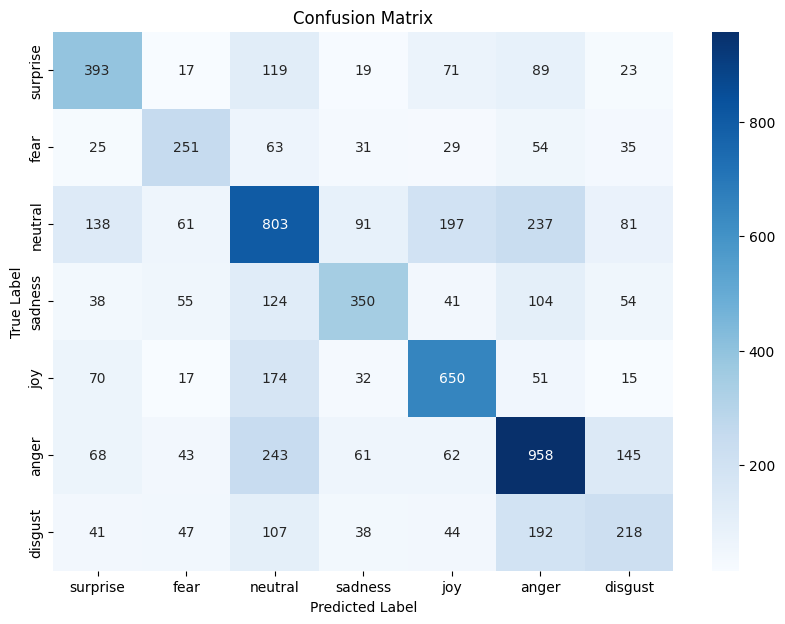

In [104]:
def plot_confusion_matrix(model, data_loader, device, label_dict):
    model.eval()
    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for batch in data_loader:
            embeddings, labels = batch
            embeddings, labels = embeddings.to(device), labels.to(device)
            embeddings = embeddings.unsqueeze(1)
            outputs = model(embeddings)
            _, predicted = torch.max(outputs.data, 1)
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    # Compute confusion matrix
    num_classes = len(label_dict)
    cm = confusion_matrix(all_labels, all_predictions, labels=list(label_dict.keys()))

    # Create a list of class names for plotting
    class_names = [label_dict[i] for i in range(num_classes)]

    # Plot confusion matrix
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names,
                yticklabels=class_names)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

plot_confusion_matrix(model, test_loader, device, itol)